In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
df = pd.read_csv('.\\data\\eda_data_dummies.csv')
df.head()

,DATA_VOLUME_WEEKDAYS,social_networks_and_messengers_count,DATA_VOLUME_WEEKENDS,CALCULATION_METHOD_ID,video_content_and_streaming_count,cloud_services_and_email_count,phone_value,device_type_rus_smartphone,ecommerce_score,device_type_rus_phone,...,lifetime,how_long_same_model,AVG_ARPU,SCORING,maps_and_transport_count,calls_count_in_weekdays,calls_count_in_weekends,dating_and_social_platforms_count,calls_count_out_weekdays,target
0,154.837,700.72,181.143,1,208.84,540.29,3.0,True,1,False,...,38.700000,25.0,260.739450,3,0.0,10.87,7.00,0.0,17.74,4
1,53.639,32.04,49.009,0,13.13,113.16,3.0,True,0,False,...,159.533333,10.0,52.635025,1,0.0,0.91,0.25,0.0,0.48,4
2,0.000,0.00,0.000,1,0.00,0.00,4.0,False,0,True,...,177.900000,25.0,22.189575,0,0.0,0.00,0.00,0.0,0.00,6
3,0.000,0.00,0.000,1,0.00,0.00,4.0,False,0,True,...,85.633333,25.0,41.816525,0,0.0,7.39,5.00,0.0,11.00,5
4,0.000,0.00,0.000,0,0.00,0.00,3.0,True,0,False,...,130.200000,23.0,39.863417,1,0.0,0.43,2.25,0.0,0.70,3


# Modeling

## Splite DATA

In [87]:
df = df.loc[:, ~df.columns.str.contains('_volume')].copy()
print(df.columns)

Index(['DATA_VOLUME_WEEKDAYS', 'social_networks_and_messengers_count',
       'DATA_VOLUME_WEEKENDS', 'CALCULATION_METHOD_ID',
       'video_content_and_streaming_count', 'cloud_services_and_email_count',
       'phone_value', 'device_type_rus_smartphone', 'ecommerce_score',
       'device_type_rus_phone', 'online_services_and_digital_stores_count',
       'lifetime', 'how_long_same_model', 'AVG_ARPU', 'SCORING',
       'maps_and_transport_count', 'calls_count_in_weekdays',
       'calls_count_in_weekends', 'dating_and_social_platforms_count',
       'calls_count_out_weekdays', 'target'],
      dtype='object')


In [88]:
Y = df['target']
x= df.drop(columns=['target'])

scale = MinMaxScaler()
x = scale.fit_transform(x)
x = pd.DataFrame(x, columns=df.columns[:-1])

x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size=0.2, random_state=42)
print(f"Train shape: {x_train.shape}, Test shape: {x_test.shape}")
y_labels = sorted(Y.unique())
Y.value_counts()

Train shape: (15692, 20), Test shape: (3924, 20)


target
5    5668
4    5553
3    3801
6    3097
2    1013
1     484
Name: count, dtype: int64

In [89]:
RESULTS = []

## KNN

### Basic KNN

In [90]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [91]:
y_pred = knn.predict(x_test)

<Axes: >

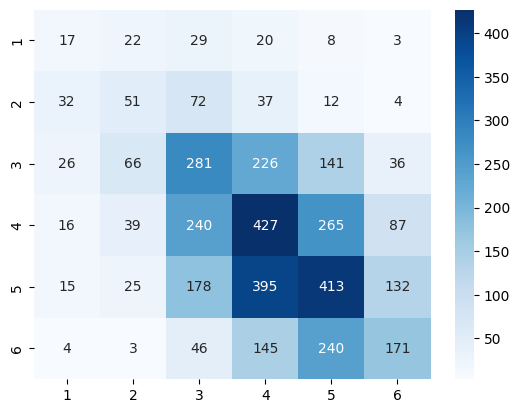

In [92]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_labels, yticklabels=y_labels)

In [93]:
cr = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))
RESULTS.append({
    'Model': 'KNN Basic',
    'Accuracy': cr['accuracy'],
    'F1-Score Weighted AVG': cr['weighted avg']['f1-score'],
    'F1-Score Macro AVG': cr['macro avg']['f1-score']
})

              precision    recall  f1-score   support

           1       0.15      0.17      0.16        99
           2       0.25      0.25      0.25       208
           3       0.33      0.36      0.35       776
           4       0.34      0.40      0.37      1074
           5       0.38      0.36      0.37      1158
           6       0.39      0.28      0.33       609

    accuracy                           0.35      3924
   macro avg       0.31      0.30      0.30      3924
weighted avg       0.35      0.35      0.35      3924



### Finetune hiperparammeters

In [94]:
knn = KNeighborsClassifier()

param_grid = {'n_neighbors': np.arange(1, 10), 'p': np.arange(1, 6)}
search = GridSearchCV(knn, param_grid, cv=5, scoring='f1_macro')
search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'p': array([1, 2, 3, 4, 5])},
             scoring='f1_macro')

In [95]:
search.best_estimator_

best_model = search.best_estimator_
y_pred = best_model.predict(x_test)

<Axes: >

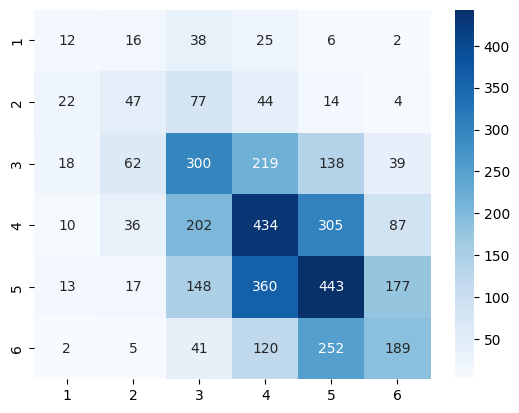

In [96]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_labels, yticklabels=y_labels)

In [97]:
cr = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))
RESULTS.append({
    'Model': 'KNN Fine-Tuned',
    'Accuracy': cr['accuracy'],
    'F1-Score Weighted AVG': cr['weighted avg']['f1-score'],
    'F1-Score Macro AVG': cr['macro avg']['f1-score']
})

              precision    recall  f1-score   support

           1       0.16      0.12      0.14        99
           2       0.26      0.23      0.24       208
           3       0.37      0.39      0.38       776
           4       0.36      0.40      0.38      1074
           5       0.38      0.38      0.38      1158
           6       0.38      0.31      0.34       609

    accuracy                           0.36      3924
   macro avg       0.32      0.31      0.31      3924
weighted avg       0.36      0.36      0.36      3924



In [98]:
knn = KNeighborsClassifier()

search = GridSearchCV(knn, 
                      param_grid={
                            'n_neighbors': np.arange(1, 10),
                            'p': np.arange(1, 6),
                            'weights': ['uniform', 'distance']
                      }
                      , cv=5, scoring='f1_macro')
search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'p': array([1, 2, 3, 4, 5]),
                         'weights': ['uniform', 'distance']},
             scoring='f1_macro')

In [99]:
best_model = search.best_estimator_
y_pred = best_model.predict(x_test)

<Axes: >

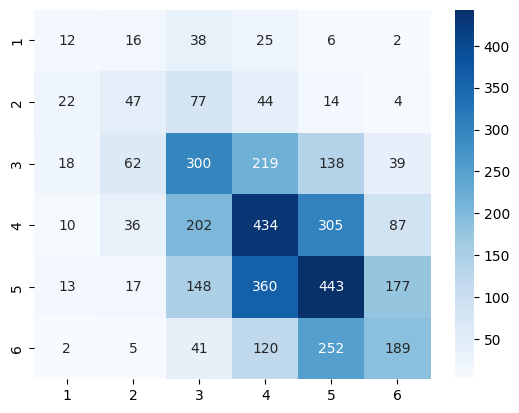

In [100]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_labels, yticklabels=y_labels)

In [101]:
cr = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))
RESULTS.append({
    'Model': 'KNN Fine-Tuned 2',
    'Accuracy': cr['accuracy'],
    'F1-Score Weighted AVG': cr['weighted avg']['f1-score'],
    'F1-Score Macro AVG': cr['macro avg']['f1-score']
})

              precision    recall  f1-score   support

           1       0.16      0.12      0.14        99
           2       0.26      0.23      0.24       208
           3       0.37      0.39      0.38       776
           4       0.36      0.40      0.38      1074
           5       0.38      0.38      0.38      1158
           6       0.38      0.31      0.34       609

    accuracy                           0.36      3924
   macro avg       0.32      0.31      0.31      3924
weighted avg       0.36      0.36      0.36      3924



## Tree

### Basic tree

In [102]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(x_train, y_train)

DecisionTreeClassifier(random_state=42)

<Axes: >

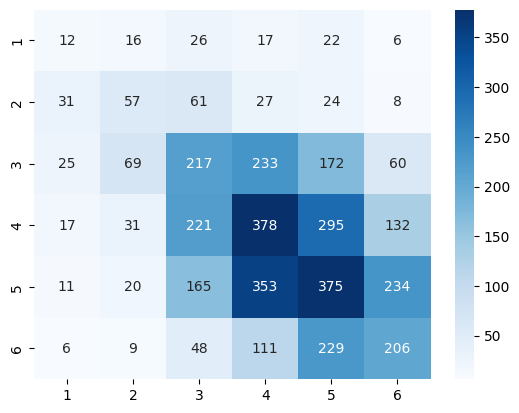

In [103]:
y_pred = tree.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_labels, yticklabels=y_labels)

In [104]:
cr = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))
RESULTS.append({
    'Model': 'Tree Basic',
    'Accuracy': cr['accuracy'],
    'F1-Score Weighted AVG': cr['weighted avg']['f1-score'],
    'F1-Score Macro AVG': cr['macro avg']['f1-score']
})

              precision    recall  f1-score   support

           1       0.12      0.12      0.12        99
           2       0.28      0.27      0.28       208
           3       0.29      0.28      0.29       776
           4       0.34      0.35      0.34      1074
           5       0.34      0.32      0.33      1158
           6       0.32      0.34      0.33       609

    accuracy                           0.32      3924
   macro avg       0.28      0.28      0.28      3924
weighted avg       0.32      0.32      0.32      3924



### Finetune hiperparammeters

In [105]:
tree = DecisionTreeClassifier(random_state=42)

search = RandomizedSearchCV(
    tree,
    param_distributions={
        'min_samples_split': np.arange(20, 200),
        'min_samples_leaf': np.arange(20, 200),
    }, cv=5, scoring='f1_macro'
)

search.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   param_distributions={'min_samples_leaf': array([ 20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
        33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
        59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
        72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  9...
       111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
       137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149,
       150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
       163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,
       176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188,
       189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199])},
                   scoring='f1_macro')

<Axes: >

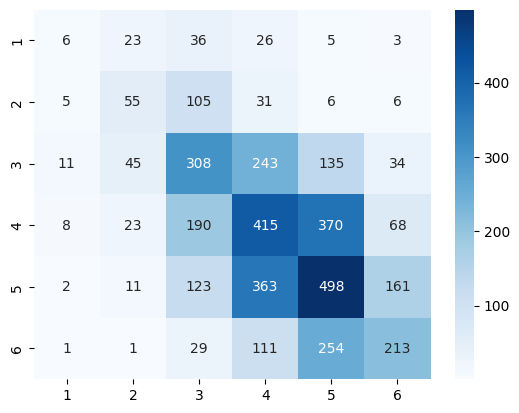

In [106]:
best_model = search.best_estimator_
y_pred = best_model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_labels, yticklabels=y_labels)

In [107]:
cr = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))
RESULTS.append({
    'Model': 'Tree Fine-Tuned',
    'Accuracy': cr['accuracy'],
    'F1-Score Weighted AVG': cr['weighted avg']['f1-score'],
    'F1-Score Macro AVG': cr['macro avg']['f1-score']
})

              precision    recall  f1-score   support

           1       0.18      0.06      0.09        99
           2       0.35      0.26      0.30       208
           3       0.39      0.40      0.39       776
           4       0.35      0.39      0.37      1074
           5       0.39      0.43      0.41      1158
           6       0.44      0.35      0.39       609

    accuracy                           0.38      3924
   macro avg       0.35      0.31      0.33      3924
weighted avg       0.38      0.38      0.38      3924



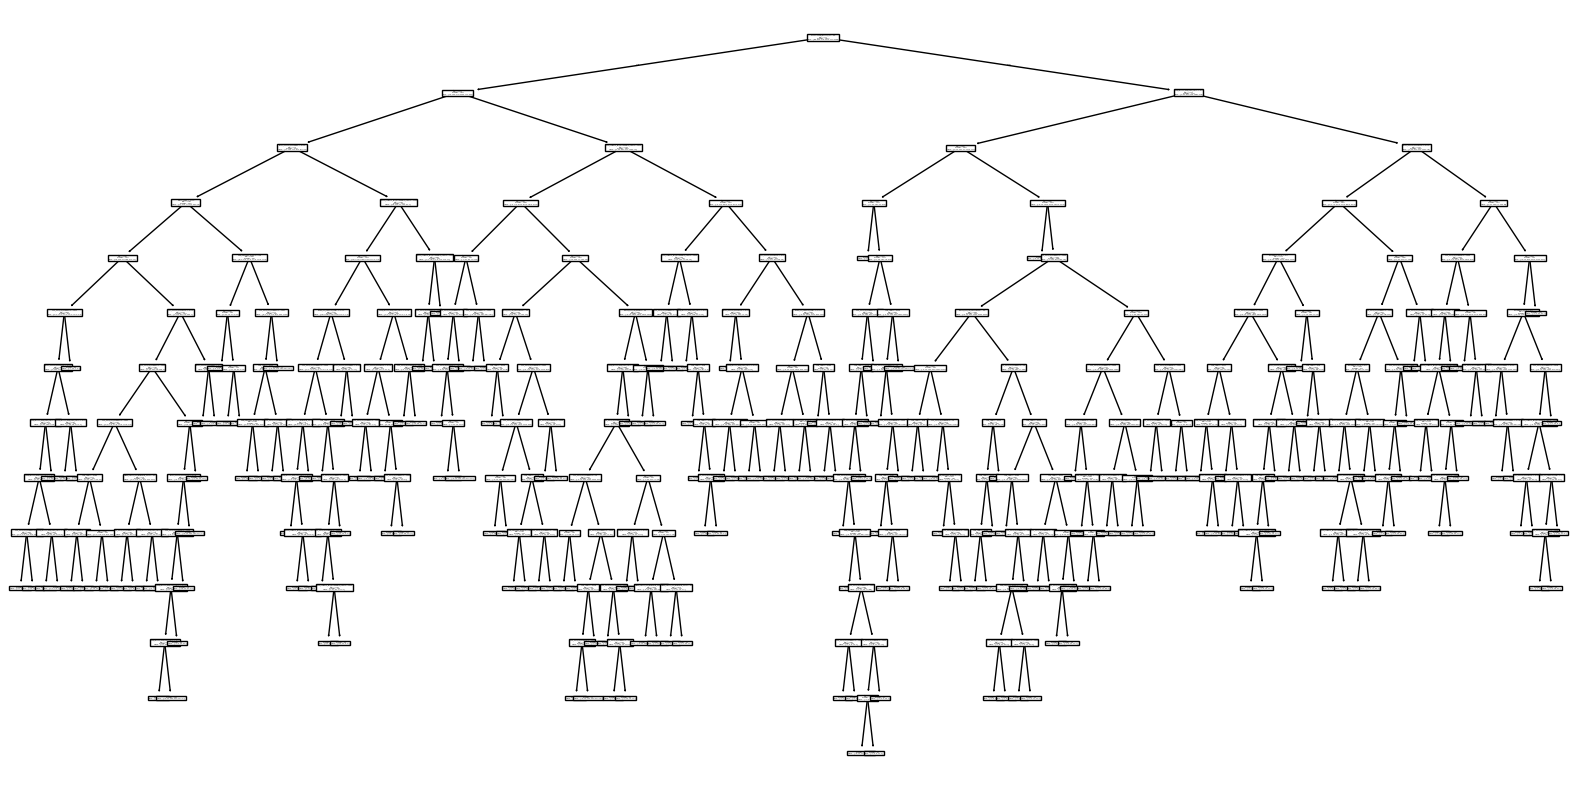

In [108]:
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(best_model, feature_names=x.columns)
plt.show()

In [109]:
tmp = pd.DataFrame({'features': x.columns, 'importances': best_model.feature_importances_}).sort_values('importances', ascending=True)
tmp.head(20)

,features,importances
18,dating_and_social_platforms_count,0.000000
10,online_services_and_digital_stores_count,0.001606
9,device_type_rus_phone,0.002864
4,video_content_and_streaming_count,0.008744
8,ecommerce_score,0.010248
15,maps_and_transport_count,0.011056
7,device_type_rus_smartphone,0.011442
6,phone_value,0.012215
12,how_long_same_model,0.022010
17,calls_count_in_weekends,0.029982


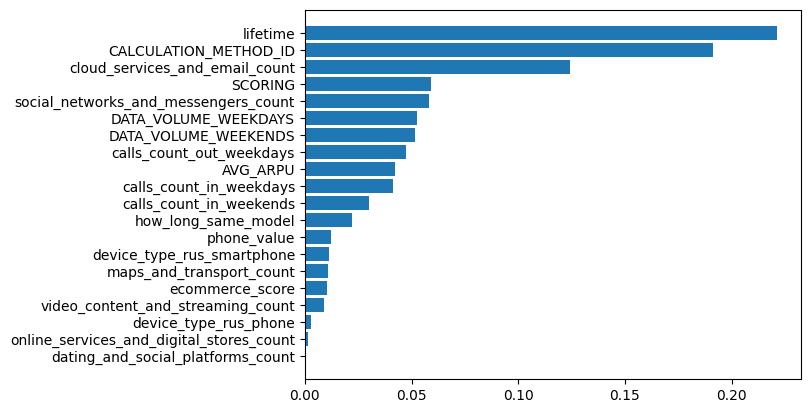

In [110]:
plt.barh(tmp['features'], tmp['importances'])
plt.show()

Best model GridSerch cv = 5 + max_depth = 12

In [111]:
tree = DecisionTreeClassifier(criterion='gini', min_samples_leaf=np.int64(37),
                       min_samples_split=np.int64(82), max_depth=12, random_state=42)
tree.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=12, min_samples_leaf=np.int64(37),
                       min_samples_split=np.int64(82), random_state=42)

12


<Axes: >

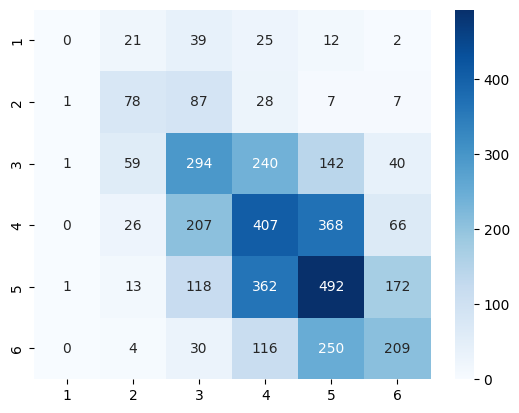

In [112]:
y_pred = tree.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(tree.get_depth())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_labels, yticklabels=y_labels)

In [113]:
cr = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))
RESULTS.append({
    'Model': 'Tree Fine-Tuned 2',
    'Accuracy': cr['accuracy'],
    'F1-Score Weighted AVG': cr['weighted avg']['f1-score'],
    'F1-Score Macro AVG': cr['macro avg']['f1-score']
})

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        99
           2       0.39      0.38      0.38       208
           3       0.38      0.38      0.38       776
           4       0.35      0.38      0.36      1074
           5       0.39      0.42      0.41      1158
           6       0.42      0.34      0.38       609

    accuracy                           0.38      3924
   macro avg       0.32      0.32      0.32      3924
weighted avg       0.37      0.38      0.37      3924



## RandomForest

### Basic RF

In [114]:
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

<Axes: >

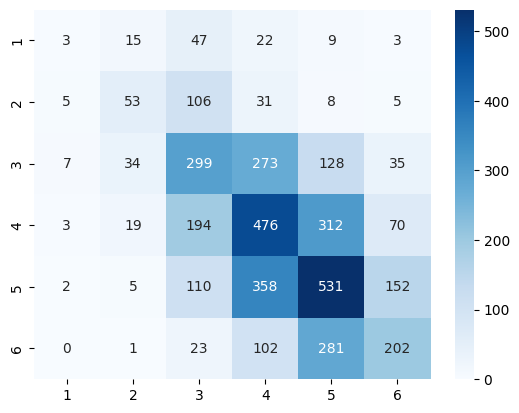

In [115]:
y_pred = rf.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_labels, yticklabels=y_labels)

In [116]:
cr = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))
RESULTS.append({
    'Model': 'RF Basic',
    'Accuracy': cr['accuracy'],
    'F1-Score Weighted AVG': cr['weighted avg']['f1-score'],
    'F1-Score Macro AVG': cr['macro avg']['f1-score']
})

              precision    recall  f1-score   support

           1       0.15      0.03      0.05        99
           2       0.42      0.25      0.32       208
           3       0.38      0.39      0.38       776
           4       0.38      0.44      0.41      1074
           5       0.42      0.46      0.44      1158
           6       0.43      0.33      0.38       609

    accuracy                           0.40      3924
   macro avg       0.36      0.32      0.33      3924
weighted avg       0.40      0.40      0.39      3924



### Finetune hiperparammeters

In [117]:
rf = RandomForestClassifier(random_state=42, criterion='gini')

search = RandomizedSearchCV(
    rf,
    param_distributions={
        'n_estimators': np.arange(50, 401, 20),
        'max_depth': np.arange(2, 21),
        'min_samples_split': np.arange(10, 151, 20),
        'min_samples_leaf': np.arange(5, 51, 5),
    }, cv=5, scoring='f1_macro'
    )
search.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20]),
                                        'min_samples_leaf': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]),
                                        'min_samples_split': array([ 10,  30,  50,  70,  90, 110, 130, 150]),
                                        'n_estimators': array([ 50,  70,  90, 110, 130, 150, 170, 190, 210, 230, 250, 270, 290,
       310, 330, 350, 370, 390])},
                   scoring='f1_macro')

<Axes: >

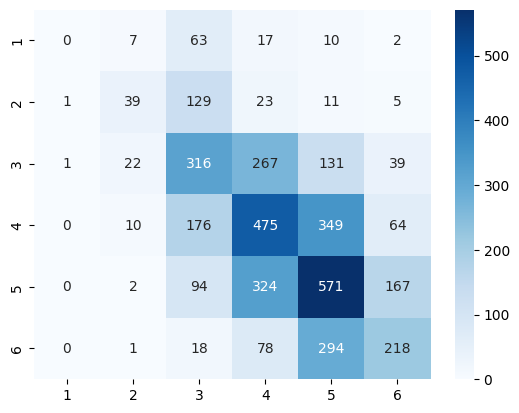

In [118]:
best_model = search.best_estimator_
y_pred = best_model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_labels, yticklabels=y_labels)

In [119]:
cr = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))
RESULTS.append({
    'Model': 'RF Fine-Tuned',
    'Accuracy': cr['accuracy'],
    'F1-Score Weighted AVG': cr['weighted avg']['f1-score'],
    'F1-Score Macro AVG': cr['macro avg']['f1-score']
})

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        99
           2       0.48      0.19      0.27       208
           3       0.40      0.41      0.40       776
           4       0.40      0.44      0.42      1074
           5       0.42      0.49      0.45      1158
           6       0.44      0.36      0.39       609

    accuracy                           0.41      3924
   macro avg       0.36      0.31      0.32      3924
weighted avg       0.41      0.41      0.40      3924



In [120]:
tmp = pd.DataFrame({'features': x.columns, 'importances': best_model.feature_importances_}).sort_values('importances', ascending=True)
tmp.head(20)

,features,importances
18,dating_and_social_platforms_count,0.003151
9,device_type_rus_phone,0.010744
15,maps_and_transport_count,0.013091
7,device_type_rus_smartphone,0.013461
8,ecommerce_score,0.014076
6,phone_value,0.018637
10,online_services_and_digital_stores_count,0.022765
14,SCORING,0.030812
4,video_content_and_streaming_count,0.046031
12,how_long_same_model,0.047137


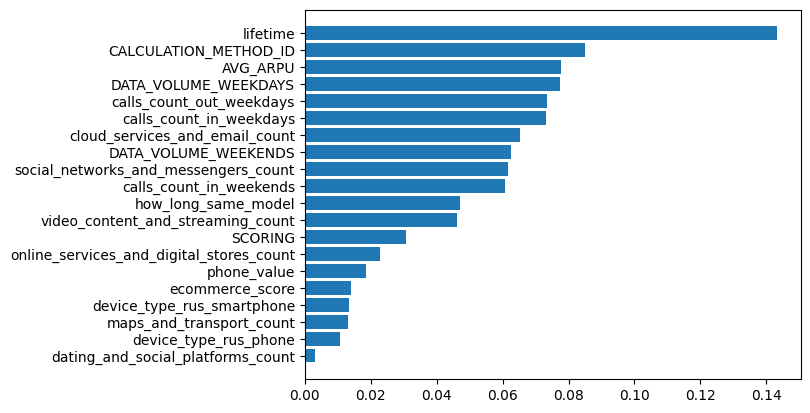

In [121]:
plt.barh(tmp['features'], tmp['importances'])
plt.show()

## LogisticRegresion

### Basic LR

In [122]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(x_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

<Axes: >

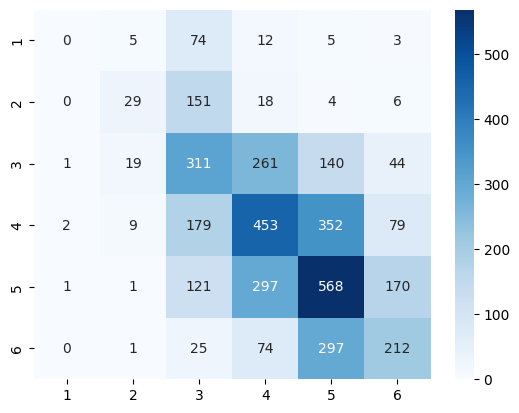

In [123]:
y_pred = log_reg.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_labels, yticklabels=y_labels)

In [124]:
cr = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))
RESULTS.append({
    'Model': 'LR Basic',
    'Accuracy': cr['accuracy'],
    'F1-Score Weighted AVG': cr['weighted avg']['f1-score'],
    'F1-Score Macro AVG': cr['macro avg']['f1-score']
})

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        99
           2       0.45      0.14      0.21       208
           3       0.36      0.40      0.38       776
           4       0.41      0.42      0.41      1074
           5       0.42      0.49      0.45      1158
           6       0.41      0.35      0.38       609

    accuracy                           0.40      3924
   macro avg       0.34      0.30      0.31      3924
weighted avg       0.39      0.40      0.39      3924



### Finetune hiperparammeters

In [125]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)

search = RandomizedSearchCV(
    log_reg,
    param_distributions={
        'C': np.logspace(-4, 4, 20),
        'penalty': ['l2', 'l1'],
        'solver': ['lbfgs', 'saga','newton-cholesky'], 
    }, cv=5, scoring='f1_macro'
)
search.fit(x_train, y_train)

C:\Users\dimal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\dimal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\dimal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\P

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=1000, random_state=42),
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'penalty': ['l2', 'l1'],
                                        'solver': ['lbfgs', 'saga',
                                                   'newton-cholesky']},
                   scoring='f1_macro')

<Axes: >

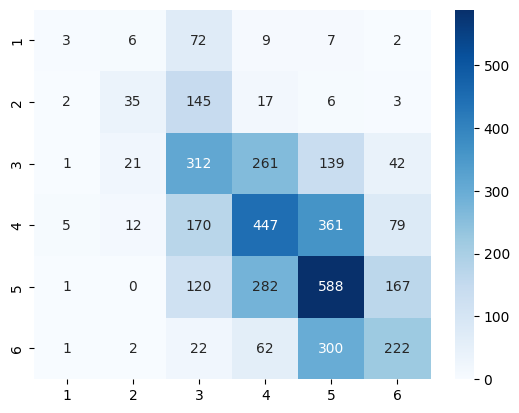

In [126]:
best_model = search.best_estimator_
y_pred = best_model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_labels, yticklabels=y_labels)

In [127]:
cr = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))
RESULTS.append({
    'Model': 'LR Fine-Tuned',
    'Accuracy': cr['accuracy'],
    'F1-Score Weighted AVG': cr['weighted avg']['f1-score'],
    'F1-Score Macro AVG': cr['macro avg']['f1-score']
})

              precision    recall  f1-score   support

           1       0.23      0.03      0.05        99
           2       0.46      0.17      0.25       208
           3       0.37      0.40      0.39       776
           4       0.41      0.42      0.42      1074
           5       0.42      0.51      0.46      1158
           6       0.43      0.36      0.40       609

    accuracy                           0.41      3924
   macro avg       0.39      0.31      0.33      3924
weighted avg       0.41      0.41      0.40      3924



## NN

### Basic Proceptron

In [128]:
nn = MLPClassifier(random_state=42, max_iter=1000)
nn.fit(x_train, y_train)

MLPClassifier(max_iter=1000, random_state=42)

<Axes: >

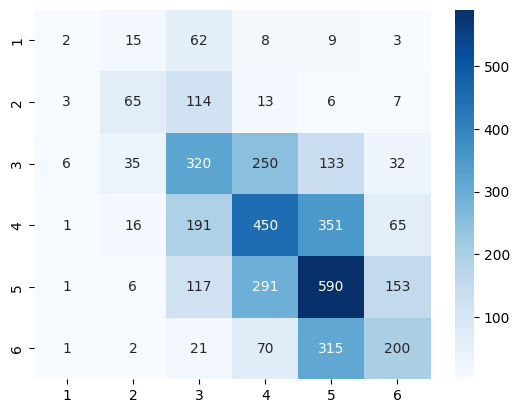

In [129]:
y_pred = nn.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_labels, yticklabels=y_labels)

In [130]:
cr = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))
RESULTS.append({
    'Model': 'MLP Basic',
    'Accuracy': cr['accuracy'],
    'F1-Score Weighted AVG': cr['weighted avg']['f1-score'],
    'F1-Score Macro AVG': cr['macro avg']['f1-score']
})

              precision    recall  f1-score   support

           1       0.14      0.02      0.04        99
           2       0.47      0.31      0.37       208
           3       0.39      0.41      0.40       776
           4       0.42      0.42      0.42      1074
           5       0.42      0.51      0.46      1158
           6       0.43      0.33      0.37       609

    accuracy                           0.41      3924
   macro avg       0.38      0.33      0.34      3924
weighted avg       0.41      0.41      0.41      3924



### Finetune hiperparammeters 

In [131]:
nn = MLPClassifier(random_state=42, max_iter=1000)
search = RandomizedSearchCV(
    nn,
    param_distributions={
        'hidden_layer_sizes': [(64,), (128,), (64, 64), (128, 128), (128, 64, 32)],
        'activation': ['relu', 'tanh', 'logistic'],
        'alpha': [0.0001, 0.001, 0.01],
    }, cv=5, scoring='f1_macro'
)
search.fit(x_train, y_train)

C:\Users\dimal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\dimal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\dimal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=MLPClassifier(max_iter=1000, random_state=42),
                   param_distributions={'activation': ['relu', 'tanh',
                                                       'logistic'],
                                        'alpha': [0.0001, 0.001, 0.01],
                                        'hidden_layer_sizes': [(64,), (128,),
                                                               (64, 64),
                                                               (128, 128),
                                                               (128, 64, 32)]},
                   scoring='f1_macro')

<Axes: >

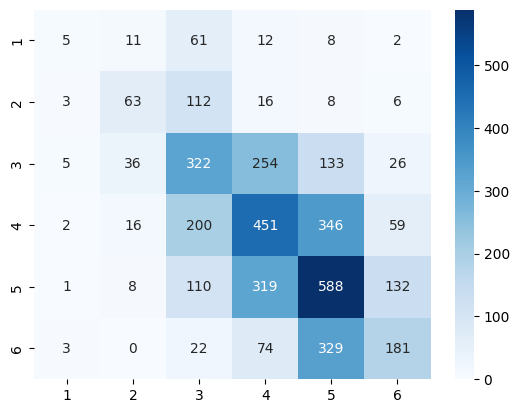

In [132]:
best_model = search.best_estimator_
y_pred = best_model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_labels, yticklabels=y_labels)

In [133]:
cr = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred, digits=4))
RESULTS.append({
    'Model': 'MLP Fine-Tuned',
    'Accuracy': cr['accuracy'],
    'F1-Score Weighted AVG': cr['weighted avg']['f1-score'],
    'F1-Score Macro AVG': cr['macro avg']['f1-score']
})

              precision    recall  f1-score   support

           1     0.2632    0.0505    0.0847        99
           2     0.4701    0.3029    0.3684       208
           3     0.3894    0.4149    0.4017       776
           4     0.4005    0.4199    0.4100      1074
           5     0.4164    0.5078    0.4576      1158
           6     0.4458    0.2972    0.3567       609

    accuracy                         0.4103      3924
   macro avg     0.3976    0.3322    0.3465      3924
weighted avg     0.4103    0.4103    0.4037      3924



## RESULTS

In [136]:
RESULTS = pd.DataFrame(RESULTS)
RESULTS.sort_values(by='F1-Score Macro AVG', ascending=False, inplace=True)
RESULTS

,Model,Accuracy,F1-Score Weighted AVG,F1-Score Macro AVG
11,MLP Fine-Tuned,0.410296,0.403722,0.346525
10,MLP Basic,0.414628,0.408051,0.343665
6,RF Basic,0.398573,0.393041,0.328663
9,LR Fine-Tuned,0.409531,0.401358,0.325992
4,Tree Fine-Tuned,0.380989,0.377940,0.325214
7,RF Fine-Tuned,0.412589,0.403780,0.323340
5,Tree Fine-Tuned 2,0.377166,0.372378,0.317562
2,KNN Fine-Tuned 2,0.363150,0.361458,0.310238
1,KNN Fine-Tuned,0.363150,0.361458,0.310238
8,LR Basic,0.400866,0.391143,0.305788


## Combine Classes

### Class `1`, `2` -> `3`

In [143]:
Y[Y.isin([1, 2])] = 3
Y.value_counts()
x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size=0.2, random_state=42)
print(f"Train shape: {x_train.shape}, Test shape: {x_test.shape}")

Train shape: (15692, 20), Test shape: (3924, 20)


C:\Users\dimal\AppData\Local\Temp\ipykernel_19124\1729451365.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y[Y.isin([1, 2])] = 3


In [145]:
nn = MLPClassifier(random_state=42, max_iter=1000, learning_rate='adaptive')
search = RandomizedSearchCV(
    nn,
    param_distributions={
        'hidden_layer_sizes': [(64,), (128,), (64, 64), (128, 128), (128, 64, 32)],
        'activation': ['relu', 'tanh', 'logistic'],
        'alpha': [0.0001, 0.001, 0.01]
    }, cv=5, scoring='f1_macro'
)
search.fit(x_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=MLPClassifier(learning_rate='adaptive',
                                           max_iter=1000, random_state=42),
                   param_distributions={'activation': ['relu', 'tanh',
                                                       'logistic'],
                                        'alpha': [0.0001, 0.001, 0.01],
                                        'hidden_layer_sizes': [(64,), (128,),
                                                               (64, 64),
                                                               (128, 128),
                                                               (128, 64, 32)]},
                   scoring='f1_macro')

              precision    recall  f1-score   support

           3     0.5759    0.6796    0.6235      1083
           4     0.4576    0.2663    0.3367      1074
           5     0.4210    0.5337    0.4707      1158
           6     0.4123    0.3744    0.3924       609

    accuracy                         0.4760      3924
   macro avg     0.4667    0.4635    0.4558      3924
weighted avg     0.4724    0.4760    0.4640      3924



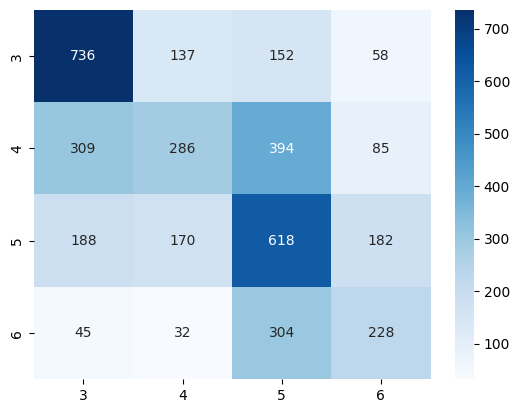

In [146]:
best_model = search.best_estimator_
y_pred = best_model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
y_labels = sorted(Y.unique())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_labels, yticklabels=y_labels)
print(classification_report(y_test, y_pred, digits=4))

### Class `6` -> `5`

In [149]:
Y[Y.isin([6])] = 5
x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size=0.2, random_state=42)
print(f"Train shape: {x_train.shape}, Test shape: {x_test.shape}")
Y.value_counts()

Train shape: (15692, 20), Test shape: (3924, 20)


C:\Users\dimal\AppData\Local\Temp\ipykernel_19124\3498690067.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y[Y.isin([6])] = 5


target
5    8765
4    5553
3    5298
Name: count, dtype: int64

In [150]:
nn = MLPClassifier(random_state=42, max_iter=1000, learning_rate='adaptive')
search = RandomizedSearchCV(
    nn,
    param_distributions={
        'hidden_layer_sizes': [(64,), (128,), (64, 64), (128, 128), (128, 64, 32)],
        'activation': ['relu', 'tanh', 'logistic'],
        'alpha': [0.0001, 0.001, 0.01]
    }, cv=5, scoring='f1_macro'
)
search.fit(x_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=MLPClassifier(learning_rate='adaptive',
                                           max_iter=1000, random_state=42),
                   param_distributions={'activation': ['relu', 'tanh',
                                                       'logistic'],
                                        'alpha': [0.0001, 0.001, 0.01],
                                        'hidden_layer_sizes': [(64,), (128,),
                                                               (64, 64),
                                                               (128, 128),
                                                               (128, 64, 32)]},
                   scoring='f1_macro')

              precision    recall  f1-score   support

           3     0.6140    0.5993    0.6065      1083
           4     0.4716    0.2393    0.3175      1074
           5     0.6219    0.8172    0.7063      1767

    accuracy                         0.5989      3924
   macro avg     0.5691    0.5519    0.5434      3924
weighted avg     0.5786    0.5989    0.5723      3924



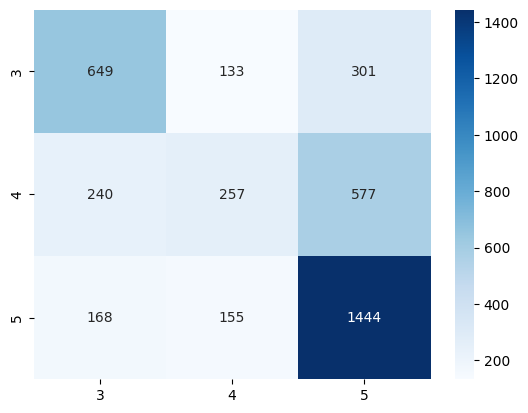

In [151]:
best_model = search.best_estimator_
y_pred = best_model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
y_labels = sorted(Y.unique())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_labels, yticklabels=y_labels)
print(classification_report(y_test, y_pred, digits=4))

In [152]:
rf = RandomForestClassifier(random_state=42, criterion='gini')

search = RandomizedSearchCV(
    rf,
    param_distributions={
        'n_estimators': np.arange(50, 401, 20),
        'max_depth': np.arange(2, 21),
        'min_samples_split': np.arange(10, 151, 20),
        'min_samples_leaf': np.arange(5, 51, 5),
    }, cv=5, scoring='f1_macro'
    )
search.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20]),
                                        'min_samples_leaf': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]),
                                        'min_samples_split': array([ 10,  30,  50,  70,  90, 110, 130, 150]),
                                        'n_estimators': array([ 50,  70,  90, 110, 130, 150, 170, 190, 210, 230, 250, 270, 290,
       310, 330, 350, 370, 390])},
                   scoring='f1_macro')

              precision    recall  f1-score   support

           3     0.6290    0.6011    0.6147      1083
           4     0.4641    0.2765    0.3466      1074
           5     0.6318    0.8042    0.7077      1767

    accuracy                         0.6037      3924
   macro avg     0.5750    0.5606    0.5563      3924
weighted avg     0.5851    0.6037    0.5832      3924



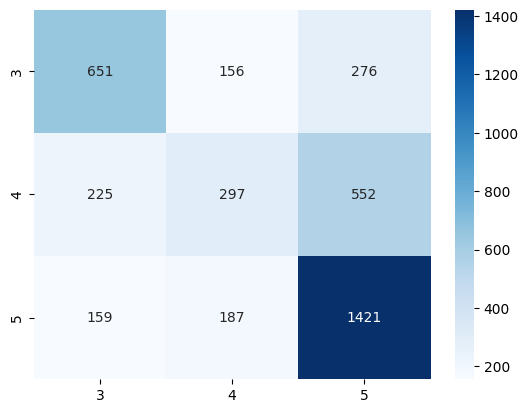

In [153]:
best_model = search.best_estimator_
y_pred = best_model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
y_labels = sorted(Y.unique())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_labels, yticklabels=y_labels)
print(classification_report(y_test, y_pred, digits=4))

In [155]:
tmp = pd.DataFrame({'features': x.columns, 'importances': best_model.feature_importances_}).sort_values('importances', ascending=True)
tmp.head(20)

,features,importances
18,dating_and_social_platforms_count,0.001391
15,maps_and_transport_count,0.009299
9,device_type_rus_phone,0.009836
7,device_type_rus_smartphone,0.015683
6,phone_value,0.016645
14,SCORING,0.018666
10,online_services_and_digital_stores_count,0.020128
8,ecommerce_score,0.020478
12,how_long_same_model,0.033546
17,calls_count_in_weekends,0.039152


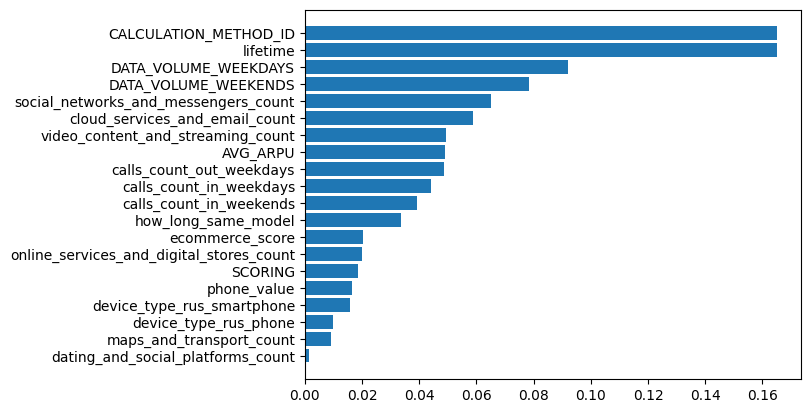

In [156]:
plt.barh(tmp['features'], tmp['importances'])
plt.show()

# Summary

As we can see from the models obtained, after reducing the number of classes to 3, we obtained a very good definition for classes `3` and `5`, but for class `4`, we see a gradual decrease after reducing the number of classes from `6` to `4` and `3`. From the last table, we can see that class `4` is very similar in definition to class `5`, accounting for almost **40%** of all members of this class. If we reduce the number of classes to 2, we will most likely get a good estimate, but they will be very unbalanced. Therefore, I believe that at this stage, we can stop and try to divide into 3 classes, because further division will lead to the loss of meaning of this modeling.